# **Cofee Sales**

**created by : Rajat Singh at Unified Mentor**

**Objective:**


**1. Loaded and cleaned the coffee sales data.**


`
2. Conducted exploratory data analysis (EDA) to visualize sales trends.
`

`
3. Prepared the data for machine learning by handling categorical variables and splitting the dataset.
`

`
4. Trained a simple linear regression model to predict sales.
`

`
5. Evaluated the model's performance.
`

In [394]:
#important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pymongo as pm
import os , sys
from logger import logging
from utils.exception import ProjectException
from utils.utils import get_dataframe_from_mongoDb
from config import mongo_client #importing client instance from config file
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler , LabelEncoder , OneHotEncoder 
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor , AdaBoostClassifier , BaggingRegressor 
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
warnings.filterwarnings("ignore")
import plotly.express as px

ModuleNotFoundError: No module named 'utils.exception'; 'utils' is not a package

# **Data Ingestion**

In [ ]:
df= get_dataframe_from_mongoDb("Coffee" , collection="Sales")

In [ ]:
df.columns

Index(['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         4532 non-null   object 
 1   datetime     4532 non-null   object 
 2   cash_type    4532 non-null   object 
 3   card         4176 non-null   object 
 4   money        4532 non-null   float64
 5   coffee_name  4532 non-null   object 
dtypes: float64(1), object(5)
memory usage: 212.6+ KB


In [ ]:
df.isnull().sum() #there are more than 300 NaN values inside Card column 

date             0
datetime         0
cash_type        0
card           356
money            0
coffee_name      0
dtype: int64

In [ ]:
#Replacing categorical column with Most Occurring Values
df["card"] = df["card"].fillna(df["card"].mode()[0])
 

In [ ]:
df["card"].mode()

0    ANON-0000-0000-0012
Name: card, dtype: object

In [ ]:
df.isnull().sum()


date           0
datetime       0
cash_type      0
card           0
money          0
coffee_name    0
dtype: int64

In [ ]:
df.describe()

,money
count,4532.000000
mean,33.105808
std,5.033698
min,18.120000
25%,28.900000
50%,32.820000
75%,37.720000
max,40.000000


In [ ]:
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [ ]:
#Lets convert date into pd.datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4532 non-null   datetime64[ns]
 1   datetime     4532 non-null   datetime64[ns]
 2   cash_type    4532 non-null   object        
 3   card         4532 non-null   object        
 4   money        4532 non-null   float64       
 5   coffee_name  4532 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 212.6+ KB


In [ ]:
#lets add some Extra columns month and year using datetime for more visualizations
df["month"]=df["date"].dt.month
df["year"]=df["date"].dt.year
df["hour"]= df["datetime"].dt.hour
df["day"]=df["date"].dt.day 
df["week_day_name"] = df["datetime"].dt.day_name() #week day with names
df["week_day_num"] = df["datetime"].dt.weekday+1 #week day in numericals values


In [ ]:
df.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


In [ ]:
#lets check how many numnericals and categorical features are there
print(df.info() , "\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4532 non-null   datetime64[ns]
 1   datetime       4532 non-null   datetime64[ns]
 2   cash_type      4532 non-null   object        
 3   card           4532 non-null   object        
 4   money          4532 non-null   float64       
 5   coffee_name    4532 non-null   object        
 6   month          4532 non-null   int32         
 7   year           4532 non-null   int32         
 8   hour           4532 non-null   int32         
 9   day            4532 non-null   int32         
 10  week_day_name  4532 non-null   object        
 11  week_day_num   4532 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(5), object(4)
memory usage: 336.5+ KB
None 



,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


 `
 There are 3 numericals and 3 categorical features
 `
 
`
 Categoricals column : cash , card , cofee_name
`

`
 Numericals column : month , year , money
 `

`
 datetime column : date  and datetime
 `

# **separating categorical and numericals feature**

In [ ]:
for column in df.columns:
    print("----------------------------------------")
    print(f"{column} has  {df[column].duplicated().sum()} Duplicates values")
 

----------------------------------------
date has  4382 Duplicates values
----------------------------------------
datetime has  3399 Duplicates values
----------------------------------------
cash_type has  4530 Duplicates values
----------------------------------------
card has  4086 Duplicates values
----------------------------------------
money has  4516 Duplicates values
----------------------------------------
coffee_name has  4524 Duplicates values
----------------------------------------
month has  4527 Duplicates values
----------------------------------------
year has  4531 Duplicates values
----------------------------------------
hour has  4516 Duplicates values
----------------------------------------
day has  4501 Duplicates values
----------------------------------------
week_day_name has  4525 Duplicates values
----------------------------------------
week_day_num has  4525 Duplicates values


In [ ]:
df_copy = df.copy()

In [ ]:
filter_df=df_copy.drop(["date" , "datetime"]  , axis=1 )


In [ ]:
numericals_columns=[]
for num_column in filter_df.columns:
    if filter_df[num_column].dtype!="O":
        numericals_columns.append(num_column)

categorical_columns=[]    
for cate_column in filter_df.columns:
    if filter_df[cate_column].dtype=="O":
        categorical_columns.append(cate_column)  

print("Numericals columns are :",numericals_columns)     
print("Categoricals columns are :",categorical_columns)     

Numericals columns are : ['money', 'month', 'year', 'hour', 'day', 'week_day_num']
Categoricals columns are : ['cash_type', 'card', 'coffee_name', 'week_day_name']


# **lets check Uniques values for Each Columns**

In [ ]:
for columns in numericals_columns:
    print(f"{columns} has {df_copy[columns].unique()} Uniques Values ") 

money has [38.7  28.9  33.8  40.   24.   35.   30.   25.   32.82 39.   37.72 27.92
 29.   34.   23.02 18.12] Uniques Values 
month has [3 4 5 6 7] Uniques Values 
year has [2024] Uniques Values 
hour has [10 12 13 15 16 18 19 11 14 17  9  7 20  8 22 21] Uniques Values 
day has [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] Uniques Values 
week_day_num has [5 6 7 1 2 3 4] Uniques Values 


In [ ]:
for columns in categorical_columns:
    print(f"{columns} has {df_copy[columns].unique()} Uniques Values\n")    

cash_type has ['card' 'cash'] Uniques Values

card has ['ANON-0000-0000-0001' 'ANON-0000-0000-0002' 'ANON-0000-0000-0003'
 'ANON-0000-0000-0004' 'ANON-0000-0000-0005' 'ANON-0000-0000-0006'
 'ANON-0000-0000-0007' 'ANON-0000-0000-0008' 'ANON-0000-0000-0009'
 'ANON-0000-0000-0010' 'ANON-0000-0000-0012' 'ANON-0000-0000-0011'
 'ANON-0000-0000-0013' 'ANON-0000-0000-0014' 'ANON-0000-0000-0015'
 'ANON-0000-0000-0016' 'ANON-0000-0000-0017' 'ANON-0000-0000-0018'
 'ANON-0000-0000-0019' 'ANON-0000-0000-0020' 'ANON-0000-0000-0021'
 'ANON-0000-0000-0022' 'ANON-0000-0000-0023' 'ANON-0000-0000-0024'
 'ANON-0000-0000-0025' 'ANON-0000-0000-0026' 'ANON-0000-0000-0027'
 'ANON-0000-0000-0028' 'ANON-0000-0000-0029' 'ANON-0000-0000-0030'
 'ANON-0000-0000-0031' 'ANON-0000-0000-0032' 'ANON-0000-0000-0033'
 'ANON-0000-0000-0034' 'ANON-0000-0000-0035' 'ANON-0000-0000-0036'
 'ANON-0000-0000-0037' 'ANON-0000-0000-0038' 'ANON-0000-0000-0039'
 'ANON-0000-0000-0040' 'ANON-0000-0000-0041' 'ANON-0000-0000-0042'
 'ANON-

# **EDA and Feature Engineering**

In [ ]:
df_copy[numericals_columns].corr()  #there is only one label inside year

,money,month,year,hour,day,week_day_num
money,1.000000,-0.291433,NaN,0.133818,-0.128860,0.059365
month,-0.291433,1.000000,NaN,0.058285,0.138983,-0.026677
year,NaN,NaN,NaN,NaN,NaN,NaN
hour,0.133818,0.058285,NaN,1.000000,0.005219,0.018143
day,-0.128860,0.138983,NaN,0.005219,1.000000,-0.057174
week_day_num,0.059365,-0.026677,NaN,0.018143,-0.057174,1.000000


In [ ]:
#lets see top coffee sales 
top_coffee_sales=df_copy["coffee_name"].value_counts()
top_coffee_sales

coffee_name
Americano with Milk    1072
Latte                   972
Cappuccino              784
Americano               676
Cortado                 396
Hot Chocolate           296
Espresso                196
Cocoa                   140
Name: count, dtype: int64

Text(0.5, 1.0, 'Coffee Distribution')

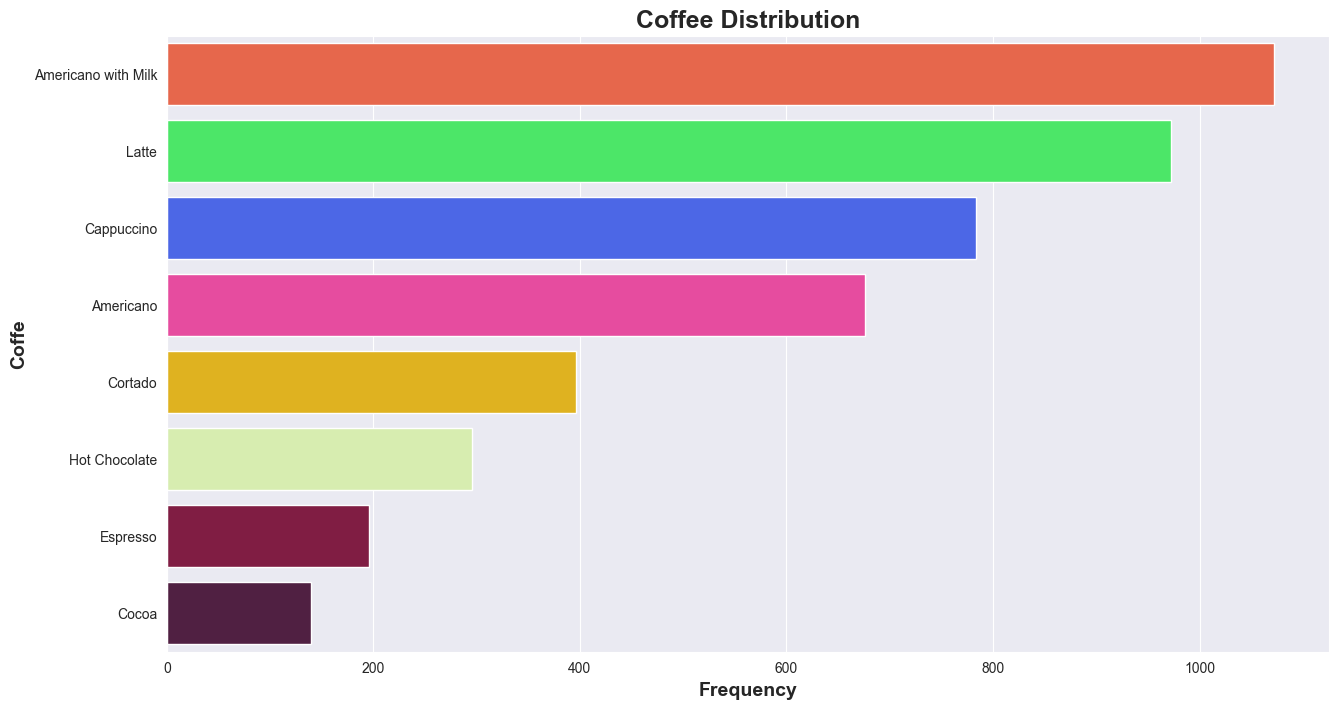

In [ ]:
custom_colors = ["#FF5733",  # Vibrant Red
                 "#33FF57",  # Bright Green
                 "#3357FF",  # Vibrant Blue
                 "#FF33A1",  # Hot Pink
                 "#FFC300",  # Yellow
                 "#DAF7A6",  # Light Green
                 "#900C3F",  # Deep Purple
                 "#581845",  # Dark Purple
                 "#FF6F61",  # Coral
                 "#C70039"] 
plt.figure(figsize=(15,8))
sns.set_palette("Spectral")
sns.set_style("darkgrid")
sns.barplot(x = top_coffee_sales.values, y=top_coffee_sales.index , palette=custom_colors)
plt.xlabel("Frequency" , fontsize=14,fontweight="bold")
plt.ylabel("Coffe" , fontsize=14 , fontweight="bold")
plt.title("Coffee Distribution" , fontsize=18 , fontweight="bold")

**Observation :**

`
1.we can see that Americano with milk  , latte and cappuccino are most popular and their sales are higher.**
`

`
2.There are less sales of hot chocolate , Espresso and Cocoa.
`

**Group by Operation  , relation between Coffee and their Prices**

**Most Profitable Product**

In [ ]:
df_copy.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


In [ ]:
# Group by coffee_name to calculate total revenue for each coffee type
coffee_revenue_df = df.groupby('coffee_name')['money'].sum().reset_index()

# Calculate the total revenue across all coffee types
total_revenue_all = coffee_revenue_df['money'].sum()

# Calculate the percentage of total revenue for each coffee type
coffee_revenue_df['percentage_of_total_revenue'] = (coffee_revenue_df['money'] / total_revenue_all) * 100

# Display the summarized revenue data by coffee type
print(coffee_revenue_df)


           coffee_name     money  percentage_of_total_revenue
0            Americano  18578.16                    12.382508
1  Americano with Milk  34407.76                    22.933076
2           Cappuccino  29332.56                    19.550410
3                Cocoa   5183.76                     3.455022
4              Cortado  10980.32                     7.318480
5             Espresso   4402.48                     2.934292
6        Hot Chocolate  11113.92                     7.407526
7                Latte  36036.56                    24.018686


In [ ]:
coffee_revenue_df

,coffee_name,money,percentage_of_total_revenue
0,Americano,18578.16,12.382508
1,Americano with Milk,34407.76,22.933076
2,Cappuccino,29332.56,19.550410
3,Cocoa,5183.76,3.455022
4,Cortado,10980.32,7.318480
5,Espresso,4402.48,2.934292
6,Hot Chocolate,11113.92,7.407526
7,Latte,36036.56,24.018686


Text(0.5, 1.0, 'Pie chart ')

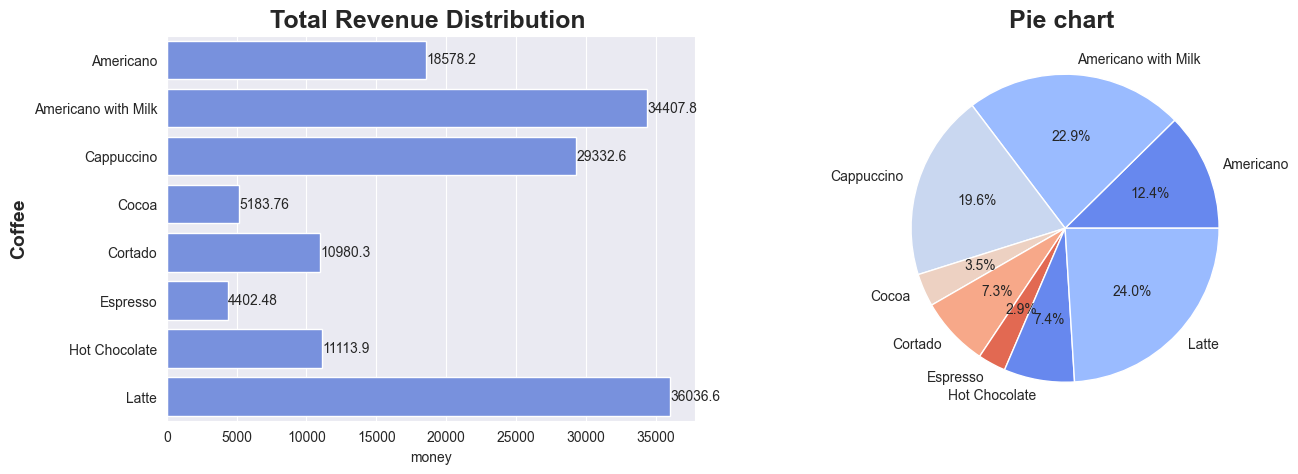

In [ ]:
sns.set_palette("coolwarm")
sns.set_style("darkgrid")
fig , (ax1 , ax2) = plt.subplots(1,2 , figsize=(15,5))
sns.barplot(data=coffee_revenue_df , y="coffee_name" , x="money", ax=ax1)
ax1.set_ylabel("Coffee" , fontsize=14 , fontweight="bold")
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_title("Total Revenue Distribution " , fontsize=18 , fontweight="bold")
ax2.pie(data=coffee_revenue_df , x="percentage_of_total_revenue"  , labels="coffee_name" , autopct='%1.1f%%')
ax2.set_title("Pie chart " , fontsize=18 , fontweight="bold")

In [ ]:

# Create pie chart with a white background
fig = px.pie(data_frame=coffee_revenue_df,
             names="coffee_name",
             values="percentage_of_total_revenue" ,
             title="<b>Coffee Payment Distribution</b>",
             height=500,
             template="simple_white",  # Clean, white background template
             color_discrete_sequence=px.colors.sequential.Aggrnyl)  # Vibrant color scheme

# Update traces for better visual appeal
fig.update_traces(textinfo='percent+label', 
                  hoverinfo='label+percent', 
                  marker=dict(line=dict(color='#FFFFFF', width=2)))  # White borders for clarity

# Customize layout for better visuals
fig.update_layout(title_font_size=24,
                  title_x=0.5,  # Center the title
                  font=dict(size=14),
                  showlegend=False,  # Hide legend if unnecessary
                  margin=dict(t=50, b=50, l=50, r=50),
                  plot_bgcolor='white',  # Ensure white background
                  paper_bgcolor='white')

**Observation:**

` 
1.we can see that that most profitable products are Americano with milk , latte , Cuppuccino and Americano .There sales are much higher than others products
`

In [ ]:
# Display available palettes
palatte_list=sns.palettes.SEABORN_PALETTES.keys()
print(palatte_list)

dict_keys(['deep', 'deep6', 'muted', 'muted6', 'pastel', 'pastel6', 'bright', 'bright6', 'dark', 'dark6', 'colorblind', 'colorblind6'])


In [ ]:
df_copy.loc[: ,["card" , "cash_type" , "coffee_name"]].describe().T

,count,unique,top,freq
card,4532,446,ANON-0000-0000-0012,708
cash_type,4532,2,card,4176
coffee_name,4532,8,Americano with Milk,1072


In [ ]:
print(df_copy[["card" , "cash_type" , "coffee_name"]].isnull().sum())



card           0
cash_type      0
coffee_name    0
dtype: int64


In [ ]:
df_copy["coffee_name"].duplicated().sum()

np.int64(4524)

`
● There are more than 4000 transactions in the data.
`




In [ ]:
# Create a histogram
fig = px.histogram(df_copy, 
                   x='cash_type', 
                   color='cash_type', 
                   title='Cash Type Distribution',
                   labels={'cash_type': 'Cash Type'},
                   text_auto=True,  # This will show the count on top of the bars
                   color_discrete_sequence=px.colors.qualitative.Set1  # Custom color palette
                  )

# Update layout for better aesthetics
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))  # Add border to bars
fig.update_layout(xaxis_title='Cash Type', 
                  yaxis_title='Frequency',
                  title_font=dict(size=18, family='Arial Black'),
                  xaxis=dict(title_font=dict(size=14)),
                  yaxis=dict(title_font=dict(size=14)),
                  legend_title_text='Cash Type',
                  legend=dict(font=dict(size=12)))

# Show the plot
fig.show()

In [ ]:

df_copy["cash_type"].value_counts()  / df_copy.shape[0]*100 #distribution based on percentage

cash_type
card    92.144748
cash     7.855252
Name: count, dtype: float64

**Observation:**

`
1.There are more than 90 percerntage card transaction.
`

`
2.0nly 7 Percentage cash payments.
`


**Payment percentage  Based on Cofee name**

In [ ]:
df_copy.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


`
Time Series Analysis
`


In [ ]:
print(f'Time Range of this dataset is from  {(df_copy["date"].min())} to  {(df_copy["date"].max())}')


Time Range of this dataset is from  2024-03-01 00:00:00 to  2024-07-31 00:00:00


# **Monthly Sale Analysis**

In [ ]:
monthly_revenue = df.groupby(['coffee_name', 'month'])['money'].sum().reset_index()
monthly_revenue

,coffee_name,month,money
0,Americano,3,4179.20
1,Americano,4,4007.76
2,Americano,5,5395.20
3,Americano,6,1563.52
4,Americano,7,3432.48
5,Americano with Milk,3,4616.00
6,Americano with Milk,4,5630.96
7,Americano with Milk,5,7633.12
8,Americano with Milk,6,9072.48
9,Americano with Milk,7,7455.20


In [ ]:
pivot_table = monthly_revenue.pivot(index='month', columns='coffee_name', values='money')
pivot_table.columns

Index(['Americano', 'Americano with Milk', 'Cappuccino', 'Cocoa', 'Cortado',
       'Espresso', 'Hot Chocolate', 'Latte'],
      dtype='object', name='coffee_name')

In [ ]:

pivot_table

coffee_name,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
month,,,,,,,,
3,4179.20,4616.00,3122.00,928.80,3476.80,964.00,3416.00,7498.00
4,4007.76,5630.96,6637.76,931.28,2193.92,684.00,2024.08,4772.48
5,5395.20,7633.12,8313.76,1363.04,1898.56,740.56,2117.44,8792.00
6,1563.52,9072.48,6940.48,759.52,2121.92,920.80,2112.32,7544.00
7,3432.48,7455.20,4318.56,1201.12,1289.12,1093.12,1444.08,7430.08


<Figure size 1000x600 with 0 Axes>

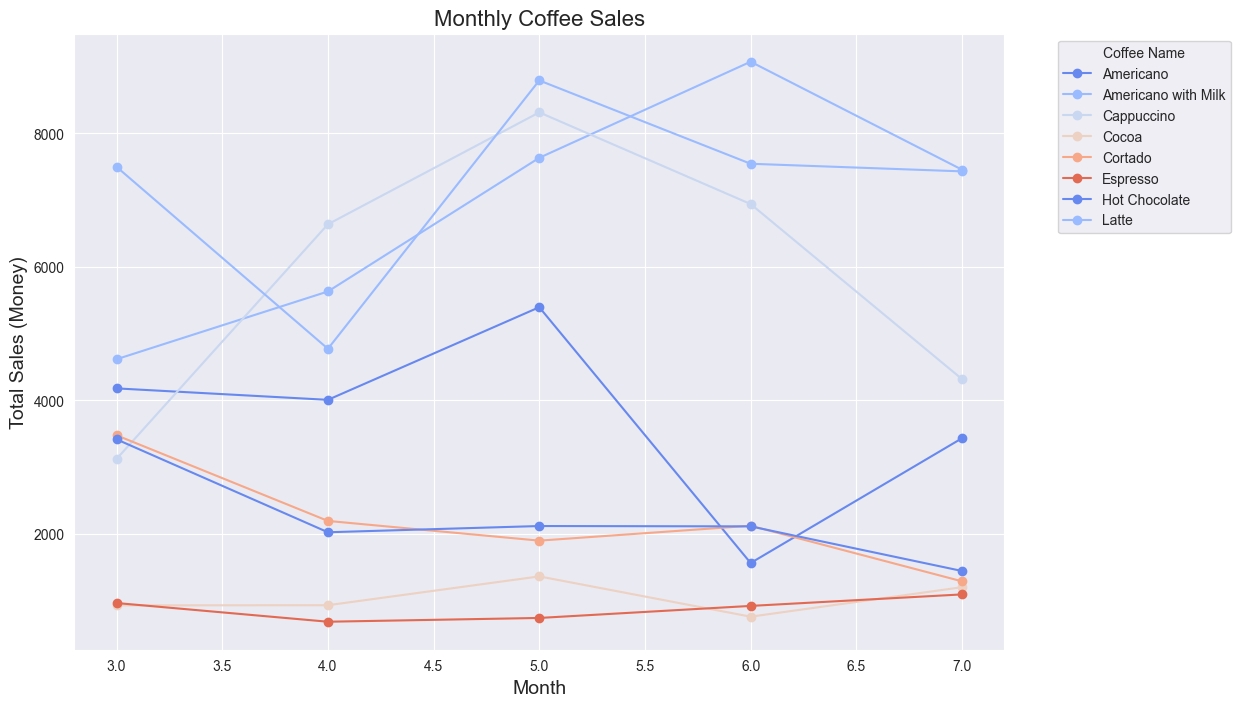

In [ ]:
# Plot the monthly sales using a line plot for each coffee type
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o', figsize=(12, 8))

plt.title('Monthly Coffee Sales', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales (Money)', fontsize=14)
plt.legend(title='Coffee Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
monthly_sales =df_copy.groupby(['coffee_name','month']).count()['date'].reset_index().rename(columns={'date':'count'}).pivot(index='month',columns='coffee_name',values='count').reset_index()
monthly_sales

coffee_name,month,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,3,144,136,80,24,120,40,88,192
1,4,140,168,172,24,76,28,52,124
2,5,192,232,220,36,68,32,56,232
3,6,56,276,184,20,76,40,56,200
4,7,144,260,128,36,56,56,44,224


In [ ]:
monthly_sales=df_copy.groupby(['coffee_name','month']).count()['date'].reset_index().rename(columns={'date':'count'})

In [ ]:
monthly_sales = monthly_sales.pivot(index='month',columns='coffee_name',values='count').reset_index()

In [ ]:
monthly_sales

coffee_name,month,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,3,144,136,80,24,120,40,88,192
1,4,140,168,172,24,76,28,52,124
2,5,192,232,220,36,68,32,56,232
3,6,56,276,184,20,76,40,56,200
4,7,144,260,128,36,56,56,44,224


In [ ]:
monthly_sales.describe().T.loc[:,['min','max']]

,min,max
coffee_name,,
month,3.0,7.0
Americano,56.0,192.0
Americano with Milk,136.0,276.0
Cappuccino,80.0,220.0
Cocoa,20.0,36.0
Cortado,56.0,120.0
Espresso,28.0,56.0
Hot Chocolate,44.0,88.0
Latte,124.0,232.0


([<matplotlib.axis.XTick at 0x1ca9ac24c70>,
 [Text(0, 0, '3'),
  Text(1, 0, '4'),
  Text(2, 0, '5'),
  Text(3, 0, '6'),
  Text(4, 0, '7')])

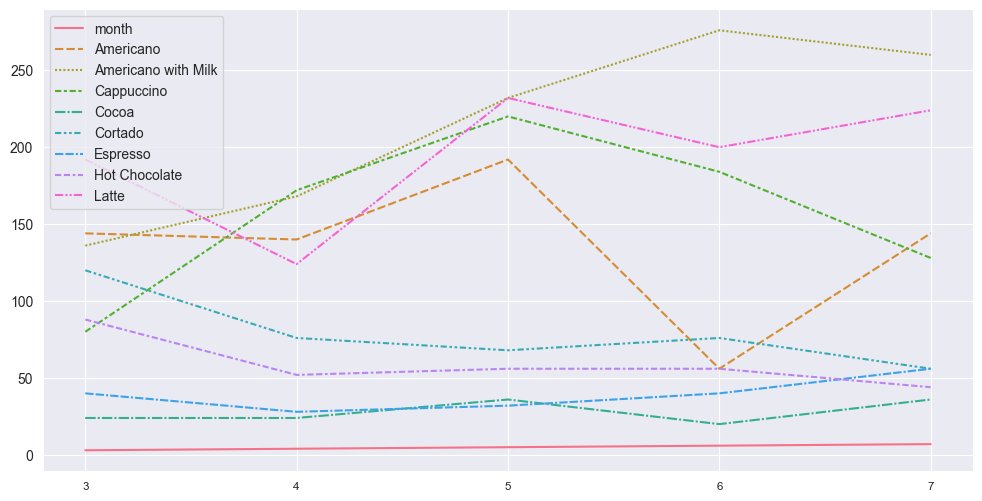

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales)
plt.legend(loc='upper left')
plt.xticks(range(len(monthly_sales['month'])),monthly_sales['month'],size='small')


**Observation:**

`
1.Seasonal Trends: Some coffee types might sell more in colder months (e.g., Americano with milh , latte), while others may peak in summer.
`

`
2.Sales Peaks: You might see higher sales in months like june and july.
`

`
3.Top-Selling Coffees: Certain coffee types, like Americano  or Latte, could consistently have higher sales each month.
`

`
4.Monthly Fluctuations: Sales may vary month-to-month, influenced by holidays, weather, or promotions.
`


`
5.Identifying Low-Performing Coffees: Some coffee types might consistently underperform (e.g., Espresso) and require reevaluation of offerings or promotions
`


# **Weekly Analysis**

In [ ]:
df_copy.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


In [ ]:
weekly_sales = df_copy.groupby(['coffee_name', 'week_day_name'])['date'].count().reset_index().rename(columns={'date': 'count'})

# Optional: Reorder the days for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales['day'] = pd.Categorical(weekly_sales['week_day_name'], categories=day_order, ordered=True)
weekly_sales = weekly_sales.sort_values(['coffee_name', 'day'])

# Display the weekly sales DataFrame
print(weekly_sales)



            coffee_name week_day_name  count        day
1             Americano        Monday    148     Monday
5             Americano       Tuesday    104    Tuesday
6             Americano     Wednesday     92  Wednesday
4             Americano      Thursday     96   Thursday
0             Americano        Friday    100     Friday
2             Americano      Saturday     68   Saturday
3             Americano        Sunday     68     Sunday
8   Americano with Milk        Monday    128     Monday
12  Americano with Milk       Tuesday    216    Tuesday
13  Americano with Milk     Wednesday    140  Wednesday
11  Americano with Milk      Thursday    124   Thursday
7   Americano with Milk        Friday    136     Friday
9   Americano with Milk      Saturday    192   Saturday
10  Americano with Milk        Sunday    136     Sunday
15           Cappuccino        Monday    124     Monday
19           Cappuccino       Tuesday    108    Tuesday
20           Cappuccino     Wednesday    116  We

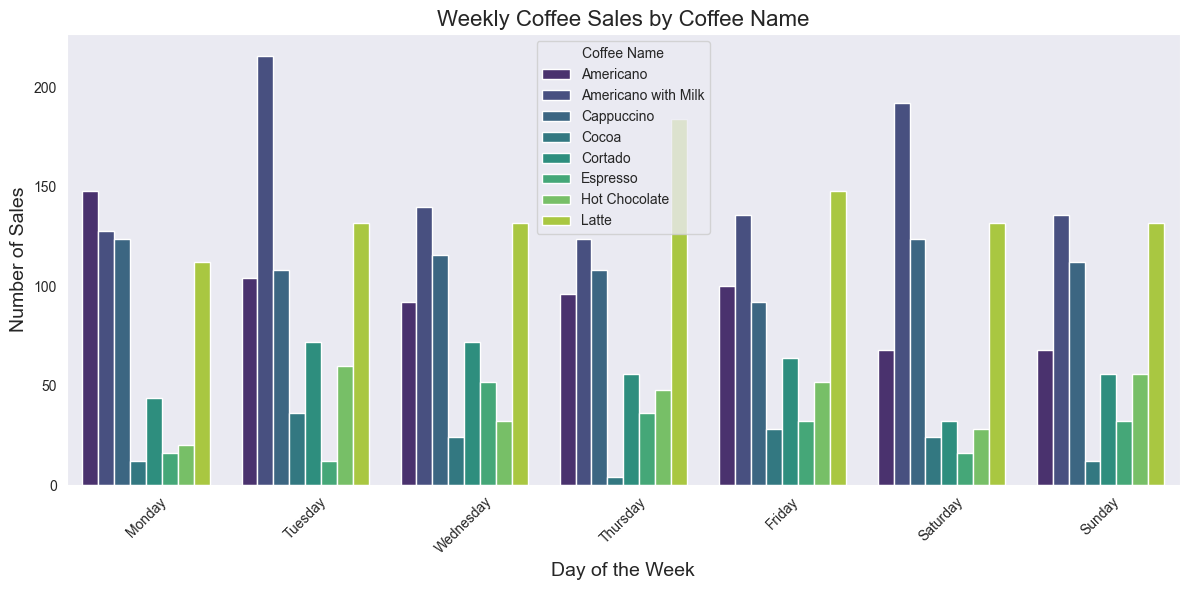

In [ ]:
# Plotting using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=weekly_sales, x='day', y='count', hue='coffee_name', palette='viridis')

plt.title('Weekly Coffee Sales by Coffee Name', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Sales', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Coffee Name')
plt.grid(axis='y')

plt.tight_layout()  # Adjust layout
plt.show()

# **Data Transformation**

In [ ]:
print(df_copy.head())

        date                datetime cash_type                 card  money  \
0 2024-03-01 2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   38.7   
1 2024-03-01 2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   38.7   
2 2024-03-01 2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   38.7   
3 2024-03-01 2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   28.9   
4 2024-03-01 2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   38.7   

     coffee_name  month  year  hour  day week_day_name  week_day_num  
0          Latte      3  2024    10    1        Friday             5  
1  Hot Chocolate      3  2024    12    1        Friday             5  
2  Hot Chocolate      3  2024    12    1        Friday             5  
3      Americano      3  2024    13    1        Friday             5  
4          Latte      3  2024    13    1        Friday             5  


In [ ]:
train_df = df_copy.drop(["date" , "datetime","week_day_name"] , axis=1)

In [ ]:
train_df

,cash_type,card,money,coffee_name,month,year,hour,day,week_day_num
0,card,ANON-0000-0000-0001,38.70,Latte,3,2024,10,1,5
1,card,ANON-0000-0000-0002,38.70,Hot Chocolate,3,2024,12,1,5
2,card,ANON-0000-0000-0002,38.70,Hot Chocolate,3,2024,12,1,5
3,card,ANON-0000-0000-0003,28.90,Americano,3,2024,13,1,5
4,card,ANON-0000-0000-0004,38.70,Latte,3,2024,13,1,5
...,...,...,...,...,...,...,...,...,...
4527,card,ANON-0000-0000-0443,23.02,Cortado,7,2024,20,31,3
4528,card,ANON-0000-0000-0040,27.92,Americano with Milk,7,2024,20,31,3
4529,card,ANON-0000-0000-0444,32.82,Latte,7,2024,21,31,3
4530,card,ANON-0000-0000-0445,32.82,Latte,7,2024,21,31,3


`
Using onehot encoder , converting each labels as separate features.
`

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False , drop="first")
encoded_column  = one_hot_encoder.fit_transform(train_df[["card" , "coffee_name"]])

In [ ]:
encoded_df=pd.DataFrame(encoded_column ,columns=one_hot_encoder.get_feature_names_out())

In [ ]:
encoded_df=encoded_df.astype(int)
encoded_df

,card_ANON-0000-0000-0002,card_ANON-0000-0000-0003,card_ANON-0000-0000-0004,card_ANON-0000-0000-0005,card_ANON-0000-0000-0006,card_ANON-0000-0000-0007,card_ANON-0000-0000-0008,card_ANON-0000-0000-0009,card_ANON-0000-0000-0010,card_ANON-0000-0000-0011,...,card_ANON-0000-0000-0444,card_ANON-0000-0000-0445,card_ANON-0000-0000-0446,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4529,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4530,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
encoded_df.index  = train_df.index
train_df=pd.concat([train_df , encoded_df] , axis=1)

In [ ]:
train_df = train_df.drop(["card" , "cash_type" , "coffee_name"] , axis=1)
train_df.head()

,money,month,year,hour,day,week_day_num,card_ANON-0000-0000-0002,card_ANON-0000-0000-0003,card_ANON-0000-0000-0004,card_ANON-0000-0000-0005,...,card_ANON-0000-0000-0444,card_ANON-0000-0000-0445,card_ANON-0000-0000-0446,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,38.7,3,2024,10,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.7,3,2024,12,1,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38.7,3,2024,12,1,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,28.9,3,2024,13,1,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38.7,3,2024,13,1,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# **Model Training**

In [ ]:
from sklearn.ensemble import AdaBoostRegressor , GradientBoostingRegressor , RandomForestRegressor
from sklearn.linear_model import Lasso , Ridge , ElasticNet

model = {

     "Linear_Regression" : LinearRegression() , 
     "Ridge" : Ridge() , 
     "Random_Forest_Regression" :RandomForestRegressor() , 
     "Gradient_Boosting_Regression" : GradientBoostingRegressor()  , 
     "Lasso"   : Lasso()   , 
     "Elastic_Net"  : ElasticNet()
}

In [ ]:
def train_evaluate_model(model , x_train , x_test , y_train , y_test):
    result=[]
    y_predictions={}
  

    for name , model  in model.items():
        model.fit(x_train , y_train)
        y_pred = model.predict(x_test)
        y_predictions[name] = y_pred
        
        MAE = mean_absolute_error(y_test , y_pred)
        MSE = mean_squared_error(y_test , y_pred)
        r2Score = r2_score(y_test , y_pred)
        result.append({"Model" : name , "MAE" :MAE , "MSE" :MSE , "r2_score":r2Score})
        
    
    return result , y_predictions

In [ ]:
x=train_df.drop("money" , axis=1)
y= train_df["money"]

x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , random_state=42)

In [ ]:
results , y_predictions=train_evaluate_model(model=model , x_train=x_train , x_test=x_test , y_train=y_train , y_test=y_test)
results = pd.DataFrame(results)

In [ ]:
results

,Model,MAE,MSE,r2_score
0,Linear_Regression,1.054620,1.713761,0.933149
1,Ridge,0.511085,0.518458,0.979776
2,Random_Forest_Regression,0.008911,0.001394,0.999946
3,Gradient_Boosting_Regression,0.383295,0.330098,0.987123
4,Lasso,4.054953,23.391193,0.087548
5,Elastic_Net,3.892873,21.655750,0.155245



# **Random Forest Model is performing very Well.**

`
Lets plot and Compare each Models Predicted values with Residuals
`

 

In [ ]:
def plot_predictions_and_residuals(model_name:str, y_test, y_pred  , plot_name:str):

    """"
    ============================================================

    model_name :str 

    y_test : test(target)
    
    y_pred : predicted_values

    plot_name  :str =(eg:- linear_model_plot.png)

    =================================================================
 
    """
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Plot 1: True vs Predicted values
    plt.figure(figsize=(14, 6))
    
    # Subplot for predicted vs true values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted Values ({model_name})')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Residuals vs Predicted values
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, color='green', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Values ({model_name})')
    plt.legend()
    plt.grid(True)
    # Show the plots
    plt.tight_layout()
    
    #save fig 
    plt.savefig(plot_name) 
    plt.show()   
    

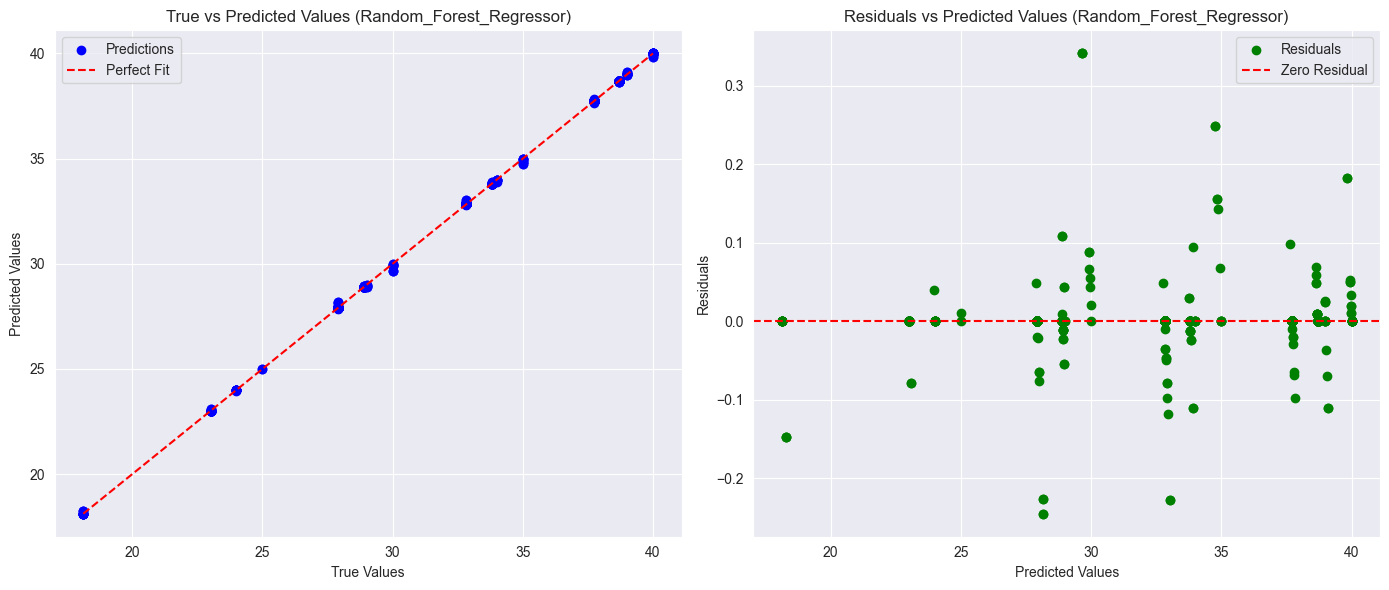

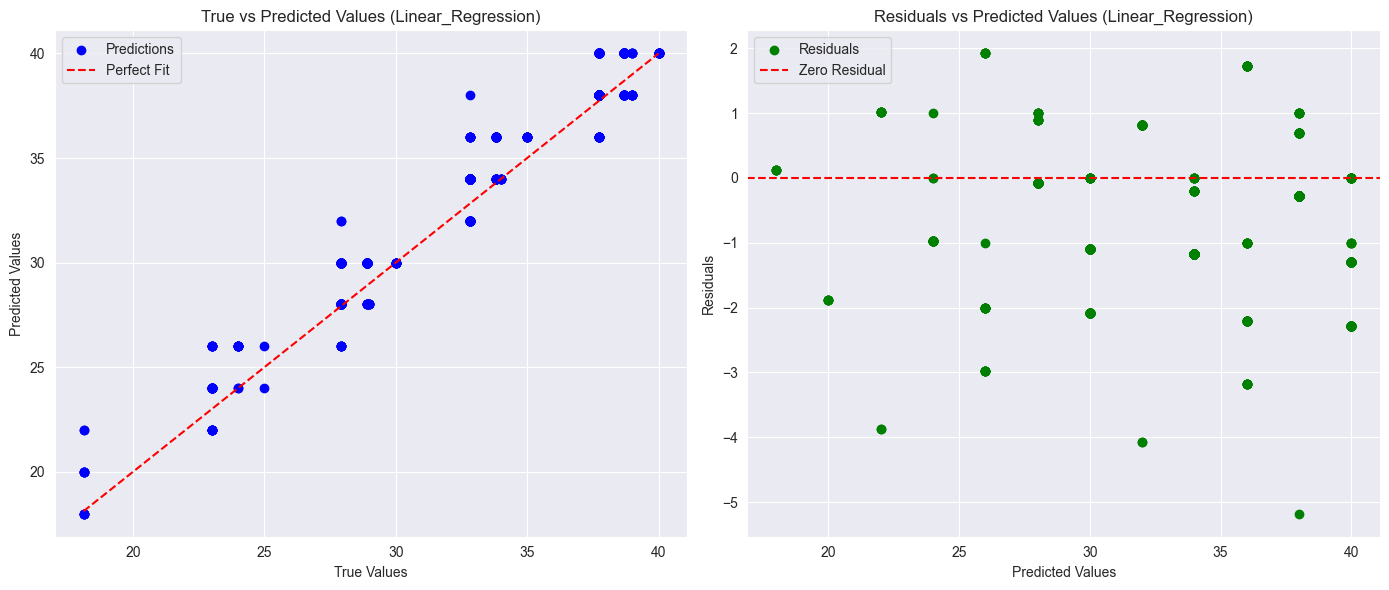

In [ ]:
linear_model_name = "Linear_Regression"
Random_model_name = "Random_Forest_Regressor"
Random_Forest_fig=plot_predictions_and_residuals(model_name=Random_model_name, y_test=y_test , y_pred=y_predictions["Random_Forest_Regression"] , plot_name="Random_Forest_Model_fig.png")
Linear_Model_Fig = plot_predictions_and_residuals(model_name=linear_model_name, y_test=y_test , y_pred=y_predictions["Linear_Regression"] ,plot_name="Linear_Model_Fig.png")
